In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from gan.wgangp import WGANGP
from gan.discriminator import Discriminator
from gan.generator import Generator
import os
from functions import data_reader as dr
import random

<h2><center>Anime character generation</center></h2>

## I. Reading data

#### 1. Reading images

In [2]:
data_path = 'data/data.zip'

In [3]:
df = dr.read_data(data_path)

100%|██████████████████████████████████████████████████████████████████████████| 63565/63565 [00:17<00:00, 3648.97it/s]


In [4]:
df.shape

(63565, 40, 40, 3)

#### 2. Visualize images

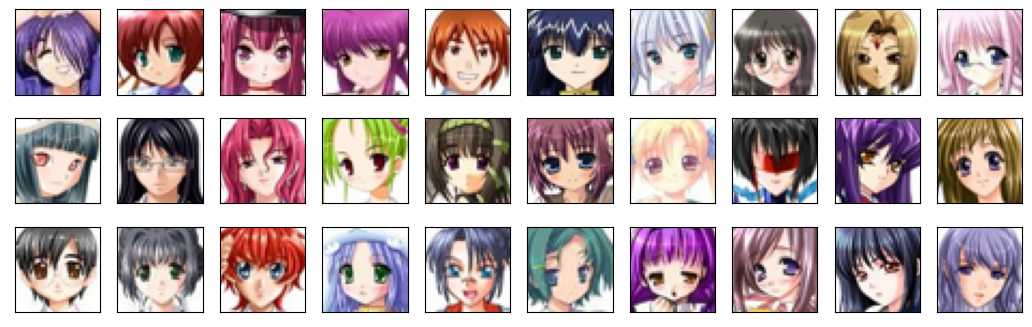

In [5]:
plt.figure(figsize=(13,4))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df[i], cmap=plt.cm.binary)
plt.show()

#### 3. Normalize data

In [6]:
X = df/255

#### 4. Train test split

In [7]:
train_ids = random.sample(range(len(X)), round(0.75*len(X)))
test_ids = list(set(range(len(X))).difference(train_ids))

In [8]:
x_train = X[train_ids]
x_test = X[test_ids]

In [9]:
print(x_train.shape)
print(x_test.shape)

(47674, 40, 40, 3)
(15891, 40, 40, 3)


## II. Train WGANGP

#### 1. Define model parameters

In [10]:
latent_dim = 100
img_shape = (40, 40, 3)

#### 2. Create generator

In [11]:
generator = Generator(latent_dim, img_shape).model

In [12]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 800)          80800       ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 10, 10, 8)    0           ['dense[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 10, 10, 16)   1168        ['reshape[0][0]']                
                                                                                          

#### 3. Create discriminator

In [13]:
discriminator = Discriminator(img_shape).model

In [14]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 40, 40, 16)   448         ['input_2[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 40, 40, 16)   64          ['input_2[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 40, 40, 16)   272         ['conv2d_11[0][0]']              
                                                                                              

#### 4. Create model

In [15]:
wgangp = WGANGP(discriminator, generator, latent_dim)
wgangp.compile()

#### 5. Train model

In [ ]:
wgangp.fit(x_train, x_train,
             batch_size=32,
             epochs=3,
             )

Epoch 1/3
1490/1490 [==============================] - 1600s 1s/step - d_loss: -73.5463 - g_loss: -13.0185
Epoch 2/3
1490/1490 [==============================] - 555s 372ms/step - d_loss: 864.1362 - g_loss: -0.5246
Epoch 3/3
1468/1490 [============================>.] - ETA: 8s - d_loss: 1538.6156 - g_loss: -1.3432

#### 6. Visualize predictions

In [ ]:
random_latent_vectors = tf.random.normal(shape=(30, latent_dim))

In [ ]:
pred = wgangp.predict(random_latent_vectors)

In [ ]:
plt.figure(figsize=(13,4))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(pred[i], cmap=plt.cm.binary)
plt.show()